In [2]:
import numpy as np 
import matplotlib.pyplot as plt

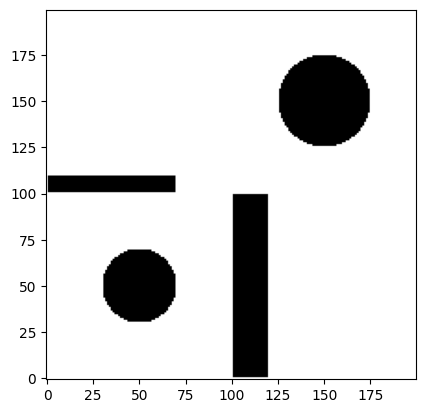

In [3]:
map = np.load("map.npy")
figure = plt.figure()
plt.imshow(map, cmap='gray', origin="lower")
plt.show()

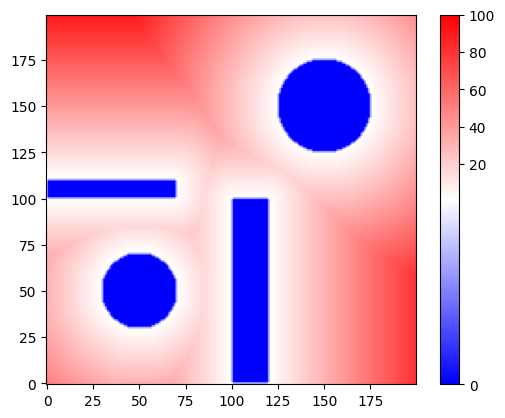

In [13]:
import skfmm as fmm
from matplotlib.colors import TwoSlopeNorm


## Compute the SDF of the map
sdf = fmm.distance(map)
figure = plt.figure()
norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=100)
cmap = plt.cm.bwr
plt.imshow(sdf, cmap=cmap, norm=norm, origin="lower")
plt.colorbar()
plt.show()



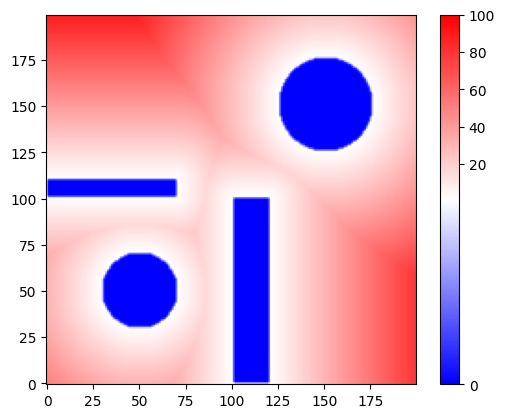

50.4814
0   0.0
1.50826   1.1380711874576983
1.50826   1.1380711874576983
0   0.0
4.92906   0.0128597


In [26]:
from casadi import interpolant

## interpolate the SDF 
xspan = (0, 200)
yspan = (0, 200)

d_knots = [np.linspace(*xspan, 200), np.linspace(*yspan, 200)] 
d_flat = sdf.ravel(order="F") ## Use the order of the flattening array as the fortran order, this is according to the documentation of casadi https://github.com/casadi/casadi/wiki/L_1p5

SDF = interpolant("SDF", "bspline", d_knots, d_flat, {"algorithm": "smooth_linear"})

new_sdf_map = np.zeros((200, 200))

for i in range(200): # row - y 
    for j in range(200): # column - x
        new_sdf_map[i, j] = SDF([i, j])

figure = plt.figure()
plt.imshow(new_sdf_map, cmap=cmap, norm=norm, origin="lower")
plt.colorbar()
plt.show()

## Test values of know SDF values
print(SDF([0, 0]))
print(SDF([50, 50]), " ", sdf[50, 50])
print(SDF([0, 100]), " ", sdf[0, 100])
print(SDF([100, 0]), " ", sdf[100, 0])
print(SDF([50, 69]), " ", sdf[50, 69])
print(SDF([115, 1]), " ", SDF([1, 115]))



In [4]:
import casadi as ca

opti = ca.Opti()
N = 40
x = opti.variable(2, N) ## This represents the positon of the robot in the world frame
# x_1 x_2 x_3 ... x_N
# y_1 y_2 y_3 ... y_N
# Be aware that we need to request 
start = (10, 10)
goal = (5, 5)
opti.subject_to(x[:, 0] == start)
opti.subject_to(x[:, -1] == goal)


u = opti.variable(6, N)
t = opti.variable(1)
opti.set_initial(t, 1)
opti.subject_to(t > 0)

A = opti.parameter(2, 6)
m = opti.parameter(1)

opti.set_value(m, 5)
opti.set_value(A, np.load("A_matrix.npy")[:2, :])

for i in range(N - 1): 
    opti.subject_to(x[:, i+1] == x[:, i]+ t *(A @ u[:, i]) / m)

for i in range(N): 
    opti.subject_to(opti.bounded(-10, u[:, i], 10))
    opti.subject_to(opti.bounded(0, x[:, i], 200))
    opti.subject_to(SDF(x[::-1, i]) >= 10)

cost = 0
for i in range(N): 
    cost += ca.sumsqr(u[:, i])

opti.minimize(cost)

p_opts = {"expand": False}   
s_opts = {"max_iter": 10000}

opti.solver("ipopt", p_opts, s_opts)
print("Vars: ", opti.nx, "\n", "Params: ", opti.ng)


try:
    sol = opti.solve()
    print("Ipopt succeeded")
except: 
    print("Ipopt failed")
    exit() 

x_opt = sol.value(x)
u_opt = sol.value(u)
t_opt = sol.value(t)

print(x_opt)
print(t_opt)

plt.figure()
plt.imshow(sdf, cmap=cmap, norm=norm, origin="lower")
plt.plot(x_opt[0, :], x_opt[1, :], "r")
plt.show()


NameError: name 'np' is not defined